# Food Delivery Duration Prediction


The objective of this notebook is to build a food delivery time prediction model which will help in the food delivery industry, where prompt and accurate delivery is of utmost importance. Delivery time directly impacts customer satisfaction and influences their overall experience.

About dataset: 

Food delivery is a courier service in which a restaurant, store, or independent food-delivery company delivers food to a customer. An order is typically made either through a restaurant or grocer's website or mobile app, or through a food ordering company. The delivered items can include entrees, sides, drinks, desserts, or grocery items and are typically delivered in boxes or bags. The delivery person will normally drive a car, but in bigger cities where homes and restaurants are closer together, they may use bikes or motorized scooters.

https://www.kaggle.com/datasets/gauravmalik26/food-delivery-dataset/data


In [1]:
import sys
import joblib
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
import xgboost as xgb
import scipy.stats as stats
import xgboost as xgb
import matplotlib.pyplot as plt
from geopy.distance import geodesic
sys.modules['sklearn.externals.joblib'] = joblib
from sklearn.externals.joblib import dump, load
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [2]:
dataset = pd.read_csv('./../../data/food-delivery-dataset/dataset.csv')
dataset.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [4]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


In [5]:
dataset.describe(exclude=np.number).T

,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


## Data Preparation

In [6]:
# Updating Weatherconditions column to Weather_conditions 
def update_column_name(df):
    df.rename(columns={'Weatherconditions': 'Weather_conditions'},inplace=True)
update_column_name(dataset)
print(dataset.columns)

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')


In [7]:
#Extract relevant values from column
def extract_column_value(df):
    #Extract time and convert to int
    df['Time_taken(min)'] = df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()))
    #Extract Weather conditions
    df['Weather_conditions'] = df['Weather_conditions'].apply(lambda x: x.split(' ')[1].strip())
    #Extract city code from Delivery person ID
    df['City_code']=df['Delivery_person_ID'].str.split("RES", expand=True)[0]

extract_column_value(dataset)
dataset[['Time_taken(min)','Weather_conditions','City_code']].head()

,Time_taken(min),Weather_conditions,City_code
0,24,Sunny,INDO
1,33,Stormy,BANG
2,26,Sandstorms,BANG
3,21,Sunny,COIMB
4,30,Cloudy,CHEN


In [8]:
# Drop ID columns which won't be use for building model
def drop_columns(df):
    df.drop(['ID','Delivery_person_ID'],axis=1,inplace=True)

drop_columns(dataset)

In [9]:
#Check for Duplicate Values
if (len(dataset[dataset.duplicated()])>0):
    print("There are Duplicate values present")
else:
    print("There is no duplicate value present")

There is no duplicate value present


In [10]:
#Update datatypes
def update_datatype(df):
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")
update_datatype(dataset)

In [11]:
#Convert String 'NaN' to np.nan
def convert_nan(df):
    df.replace('NaN', float(np.nan), regex=True,inplace=True)
convert_nan(dataset)

In [12]:
#Check null values
dataset.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weather_conditions              616
Road_traffic_density            601
Festival                        228
Order_Date                        0
Delivery_location_longitude       0
Time_Order_picked                 0
Delivery_location_latitude        0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Restaurant_longitude              0
Restaurant_latitude               0
Time_taken(min)                   0
City_code                         0
dtype: int64

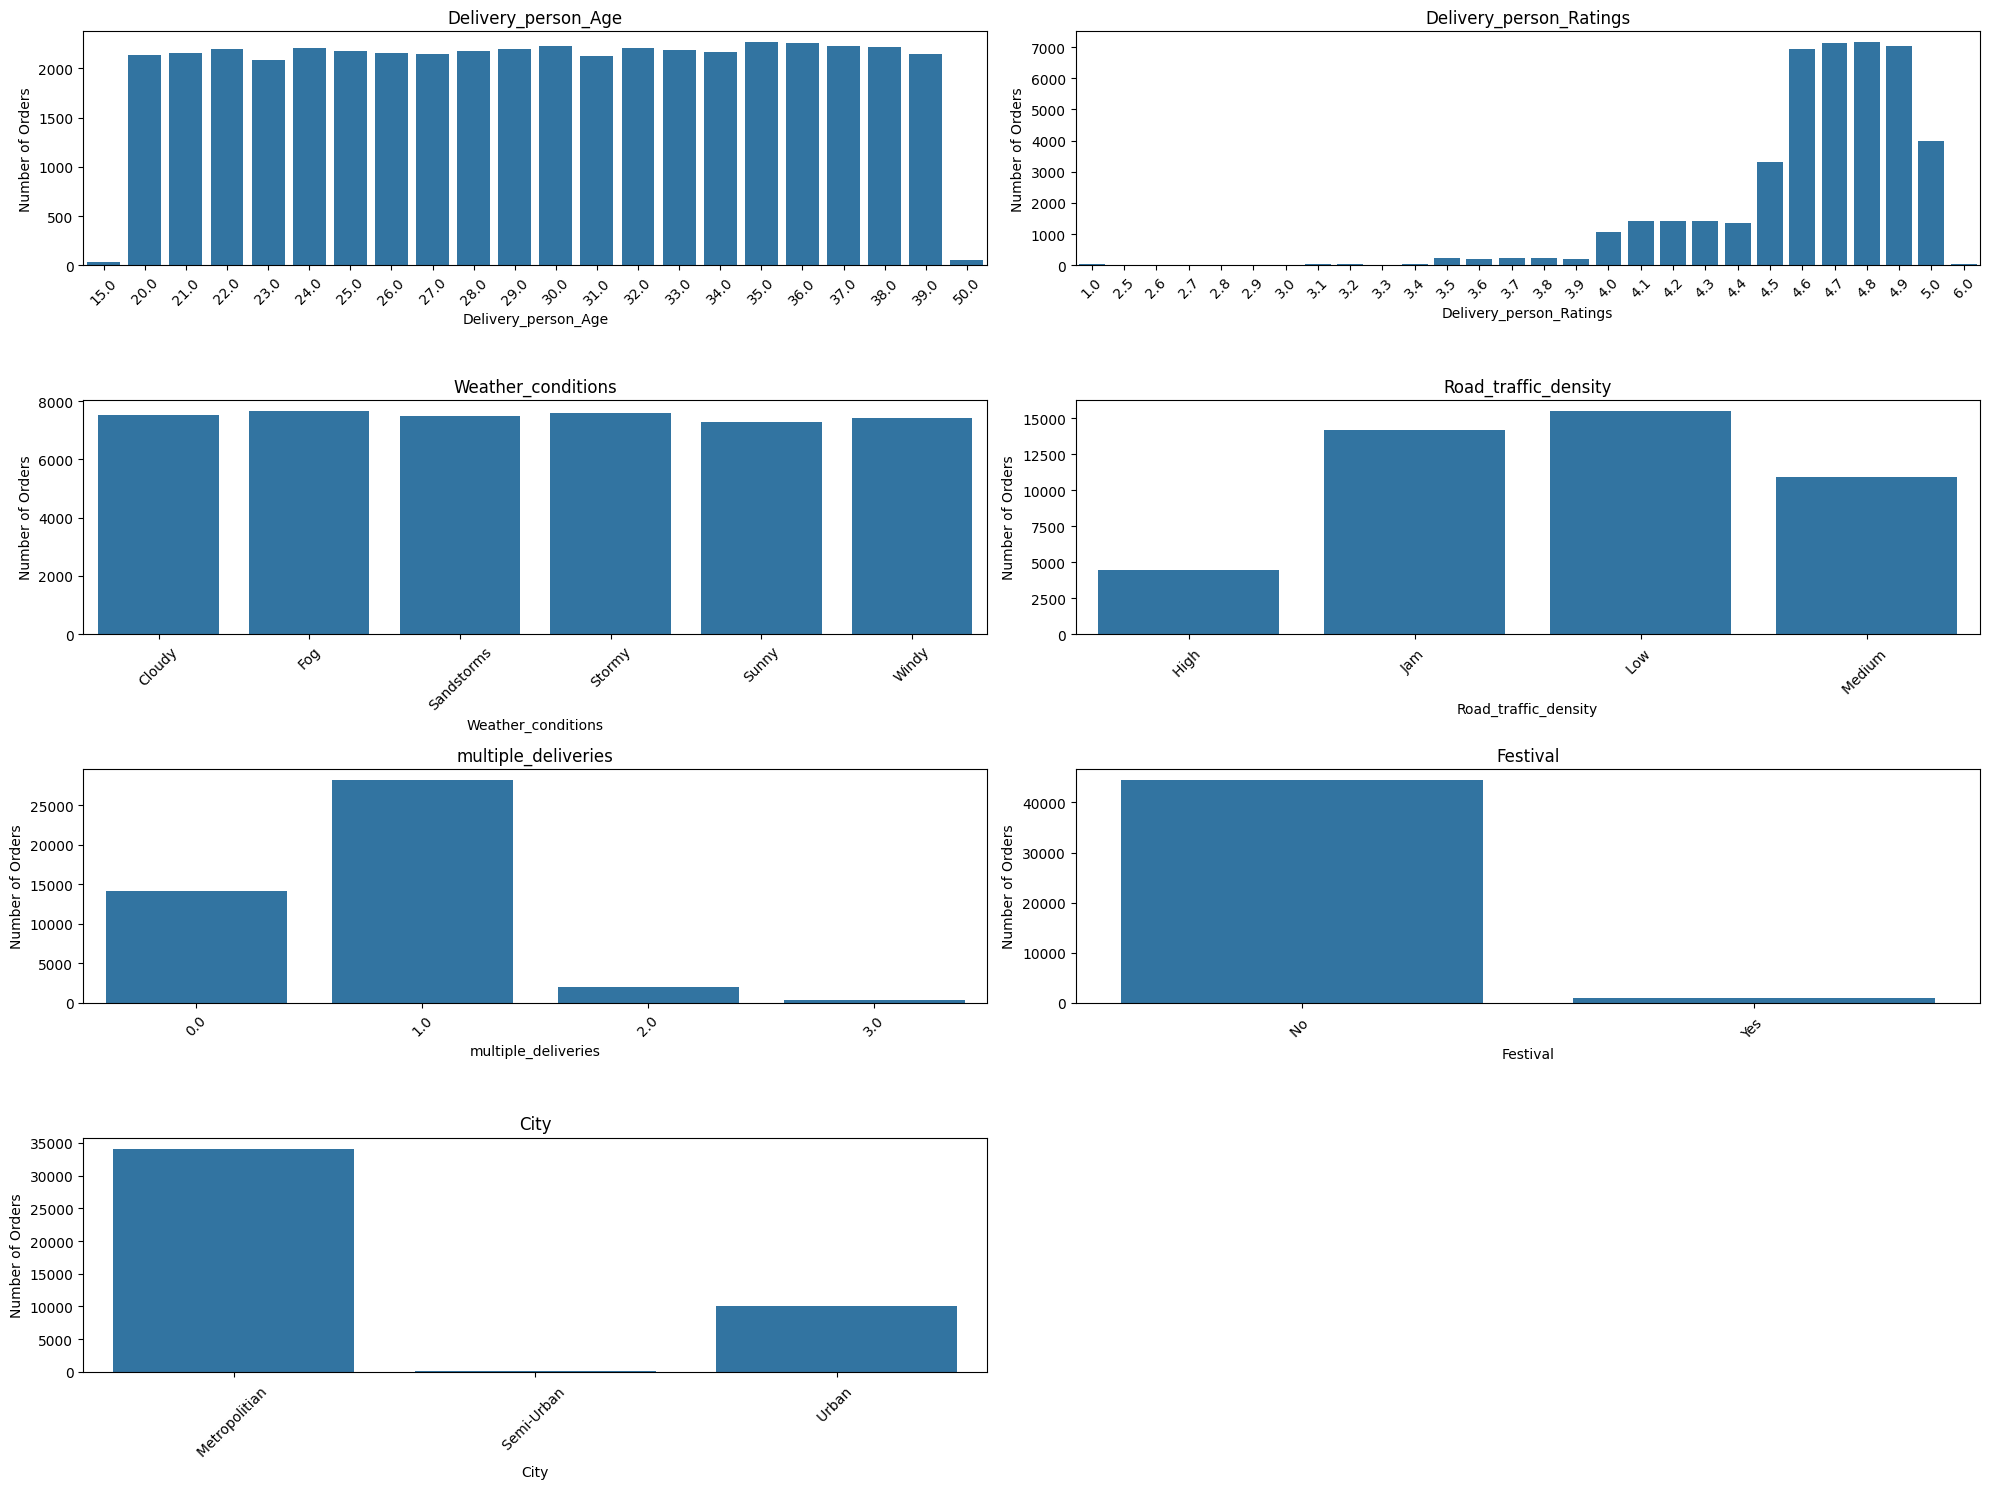

In [13]:
#Let's explore columns that have null values
cols = ['Delivery_person_Age','Delivery_person_Ratings','Weather_conditions','Road_traffic_density','multiple_deliveries','Festival','City']
num_plots = len(cols)
num_rows = (num_plots // 2) + (num_plots % 2)
fig, axes = plt.subplots(num_rows, 2, figsize=(20,15))

for i, column_name in enumerate(cols):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.countplot(data=dataset, x=column_name, order=dataset[column_name].value_counts().sort_index().index, ax=ax)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Number of Orders')
    ax.set_title(column_name)
    ax.tick_params(axis='x', rotation=45)

if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])
plt.tight_layout()
plt.show()

In [14]:
#Full fill null values
def handle_null_values(df):
    df['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']), inplace=True)
    df['Weather_conditions'].fillna(np.random.choice(df['Weather_conditions']), inplace=True)
    df['City'].fillna(df['City'].mode()[0], inplace=True)
    df['Festival'].fillna(df['Festival'].mode()[0], inplace=True)
    df['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0], inplace=True)
    df['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0], inplace=True)
    df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(), inplace=True)

handle_null_values(dataset)
dataset.isnull().sum()

Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions                0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
City_code                         0
dtype: int64

In [15]:
def extract_date_features(data):
    data["day"] = data.Order_Date.dt.day
    data["month"] = data.Order_Date.dt.month
    data["quarter"] = data.Order_Date.dt.quarter
    data["year"] = data.Order_Date.dt.year
    data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
    data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
    data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
    data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
    data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
    data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
    data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
    data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)
extract_date_features(dataset)
dataset.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,...,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,...,1,2022,5,0,0,0,0,0,0,1
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,...,1,2022,4,0,0,0,0,0,0,0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,...,1,2022,5,0,0,0,0,0,0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,...,2,2022,1,0,0,0,0,0,0,0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,...,1,2022,5,0,0,0,0,0,0,1


In [16]:
#Calculate Time Differnce
def calculate_time_diff(df):
    # Find the difference between ordered time & picked time
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])
    df['Time_Order_picked_formatted'] = df['Order_Date'] + np.where(df['Time_Order_picked'] < df['Time_Orderd'], pd.DateOffset(days=1), pd.DateOffset(days=0)) + df['Time_Order_picked']
    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']
    df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60
    # Handle null values by filling with the median
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)
    # Drop all the time & date related columns
    df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date'], axis=1, inplace=True)
calculate_time_diff(dataset)
dataset.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,...,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,...,2022,5,0,0,0,0,0,0,1,15.0
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,2,Snack,...,2022,4,0,0,0,0,0,0,0,5.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,...,2022,5,0,0,0,0,0,0,1,15.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,...,2022,1,0,0,0,0,0,0,0,10.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,...,2022,5,0,0,0,0,0,0,1,15.0


In [17]:
#Calculate distance between restaurant location & delivery location
def calculate_distance(df):
    df['distance']=np.zeros(len(df))
    restaurant_coordinates=df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    delivery_location_coordinates=df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])
    df['distance']= df['distance'].astype("str").str.extract('(\d+)').astype("int64")

calculate_distance(dataset)
dataset.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,...,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,...,5,0,0,0,0,0,0,1,15.0,3
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,2,Snack,...,4,0,0,0,0,0,0,0,5.0,20
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,...,5,0,0,0,0,0,0,1,15.0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,...,1,0,0,0,0,0,0,0,10.0,7
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,...,5,0,0,0,0,0,0,1,15.0,6


#### Label Encoding Categorical Columns

In [18]:
def label_encoding_categorical_colums(df):
    categorical_columns = df.select_dtypes(include='object').columns
    label_encoder = LabelEncoder()
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

label_encoding_categorical_colums(dataset)
dataset.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,...,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,4,0,2,3,...,5,0,0,0,0,0,0,1,15.0,3
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,3,1,2,3,...,4,0,0,0,0,0,0,0,5.0,20
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2,2,0,1,...,5,0,0,0,0,0,0,1,15.0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,4,3,0,0,...,1,0,0,0,0,0,0,0,10.0,7
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,0,0,1,3,...,5,0,0,0,0,0,0,1,15.0,6


#### Split dataset (train and test)

In [19]:
#Split features and label
X = dataset.drop('Time_taken(min)', axis=1)  # Features
y = dataset['Time_taken(min)']  # Target variable

# Split the data into train and test sets
X_train_splitted, X_test_splitted, y_train_splitted, y_test_splitted = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train_splitted.shape)
print(y_train_splitted.shape)
print(X_test_splitted.shape)
print(y_test_splitted.shape)

(36474, 29)
(36474,)
(9119, 29)
(9119,)


In [20]:
X_train_splitted

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,...,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
29044,37.0,4.8,22.308096,73.167753,22.318096,73.177753,0,0,0,0,...,0,0,0,0,0,0,0,0,10.0,1
41736,28.0,4.2,12.337978,76.616792,12.367978,76.646792,3,2,0,0,...,1,1,0,0,0,0,0,0,15.0,4
17874,24.0,4.6,22.761593,75.886362,22.831593,75.956362,5,3,2,0,...,2,0,0,0,0,0,0,0,15.0,10
42093,34.0,4.0,22.310329,73.169083,22.350329,73.209083,5,0,1,2,...,0,0,0,0,0,0,0,0,10.0,6
22952,28.0,4.8,0.000000,0.000000,0.110000,0.110000,4,1,0,1,...,4,0,0,0,0,0,0,0,5.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,37.0,4.9,10.961850,76.971082,11.071850,77.081082,4,3,2,2,...,2,0,0,0,0,0,0,0,15.0,17
44732,34.0,4.9,26.891191,75.802083,26.981191,75.892083,4,1,2,3,...,4,0,0,0,0,0,0,0,15.0,13
38158,39.0,4.9,18.927584,72.832585,18.967584,72.872585,5,0,0,2,...,1,1,0,0,0,0,0,0,10.0,6
860,25.0,4.9,13.086438,80.220672,13.136439,80.270672,5,3,2,2,...,5,0,0,0,0,0,0,1,5.0,7


In [21]:
X_train = X_train_splitted
X_test = X_test_splitted
y_train = y_train_splitted
y_test = y_test_splitted

#### Standardization features

In [22]:
# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
# Compute the mean and std to be used for later scaling.
scaler.fit(X_train)
# Perform standardization by centering and scaling on the training data
X_train = scaler.transform(X_train)
# Perform standardization by centering and scaling on the testing data
X_test = scaler.transform(X_test)
# Save scaler to be used in the inference
dump(scaler, '../../models/delivery_duration/v1/scaler_delivery_duration.bin', compress=True)

['../../models/delivery_duration/v1/scaler_delivery_duration.bin']

## Model Training

In [23]:
# Find the best model between LinearRegression, DecisionTreeRegressor, RandomForestRegressor, XGBRegressor
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(),
]

param_grid = [
    {},
    {'max_depth': [3, 5, 7]},
    {'n_estimators': [100, 200, 300]},
    {'n_estimators': [20, 25, 30], 'max_depth': [5, 7, 9]},
]

for i, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    print(f"{model.__class__.__name__}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best R2 score:", grid_search.best_score_)
    print()

LinearRegression:
Best parameters: {}
Best R2 score: 0.4251562432026482

DecisionTreeRegressor:
Best parameters: {'max_depth': 7}
Best R2 score: 0.7319639735152728

RandomForestRegressor:
Best parameters: {'n_estimators': 300}
Best R2 score: 0.8142830988827768

XGBRegressor:
Best parameters: {'max_depth': 7, 'n_estimators': 20}
Best R2 score: 0.8207505036961775



In [24]:
# Select a XGB regressor model since has Best R2 score
model = xgb.XGBRegressor(n_estimators=20, max_depth=9)

# Fit the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
# Save the model 
model_path = '../../models/delivery_duration/v1/model_delivery_duration.json'
model.save_model(model_path)

## Model Evaluation

In [26]:
loaded_model = xgb.XGBRegressor()
loaded_model.load_model(model_path)

In [27]:
# Make predictions on the test data
y_pred = loaded_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae, 2))
print("Mean Squared Error (MSE):", round(mse, 2))
print("Root Mean Squared Error (RMSE):", round(rmse,2))
print("R-squared (R2) Score:", round(r2,2))

Mean Absolute Error (MAE): 3.16
Mean Squared Error (MSE): 15.93
Root Mean Squared Error (RMSE): 3.99
R-squared (R2) Score: 0.82
